#Co-adaptive BCI based on supervised domain adaptation: results in motor imagery simulated data

Notebook credits: Valeria Spagnolo, Catalina Galván, [Victoria Peterson](https://sites.google.com/view/victoria-peterson/home)

Laboratorio de Neuroingeniería Computacional Aplicada, Instituto de Matemática Aplicada del Litoral, IMAL, UNL-CONICET
https://sites.google.com/view/nicalab

### Demo for testing A1: “Backward adaptation based on the system knowledge is successful if the provided EEG patterns are discriminative and and aligned to the indicated mental task"

In [39]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [40]:
!pip install wget
!pip3 install mne
!pip install POT
!git clone https://github.com/vpeterson/otda-mibci.git

fatal: destination path 'otda-mibci' already exists and is not an empty directory.


In [41]:
import wget
import numpy as np
import sys
sys.path.insert(1, 'otda-mibci')
from MIOTDAfunctions import*
from BOTDA import BOTDA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import mne
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
from sklearn.metrics import accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import ot
import timeit
import os.path as op
from random import sample

In [42]:
def Backward_GroupLasso_Transport(Gtr_daot, regu_, Gval, Yval, Gte, lda, metric):

    botda = ot.da.SinkhornL1l2Transport(metric=metric, reg_e=regu_[0], reg_cl=regu_[1])
    # learn params of transport
    botda.fit(Xs=Gval, ys=Yval, Xt=Gtr_daot)
    botda_matrix = botda.coupling_

    # comptue the distance
    ditance_ot =  botda.cost_
    #transport testing samples
    transp_Xt_backward=botda.transform(Xs=Gte)

    # Compute accuracy without retraining
    yt_predict = lda.predict(transp_Xt_backward)

    return yt_predict, transp_Xt_backward, botda_matrix, ditance_ot

# Part 1: Adaptantion success and ERD%

## Load and prepare data


### Calibration session

For this demo to ensure a perfect calibration session simulated data at which all trials are aligned to their corresponding class and have ERD% = 50 is used ($S_{50,0}$) for calibration purposes (model training).

In [43]:
wget.download("https://zenodo.org/records/13760210/files/S_50_epo.fif?download=1",
              out="S_50_epo.fif")
epochs_train = mne.read_epochs("S_50_epo.fif", preload=True, verbose=False)
epochs_train = epochs_train.resample(250)
epochs_train_array = epochs_train.get_data()  # Epoched data as a numpy array
epochs_train_array=mne.filter.filter_data(epochs_train_array, 250, 8, 30)
ch_names = epochs_train.ch_names  # Channels names

### Application session



For the sake of this demo, only the session with the lower ERD% value will be used as application session.

In [44]:
wget.download("https://zenodo.org/records/13760210/files/S_10_epo.fif?download=1",
              out="S_10_epo.fif")
epochs_test = mne.read_epochs("S_10_epo.fif", preload=True, verbose=False)
epochs_test = epochs_test.resample(250)
epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

## Model training

As decoding model the typical CSP + LDA is used. Here, given that we know the way simulated data was created, only two components are extracted from CSP

### Define training data

In [45]:
Xtr = epochs_train_array
Ytr = epochs_train.events[:,2]

### Fit the model

In [46]:
# Create CSP and LDA objects
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
lda = LinearDiscriminantAnalysis()
# Learn CSP filters and get the CSP features
Gtr = csp.fit_transform(Xtr, Ytr)
# Fit LDA
lda.fit(Gtr, Ytr);

(-3.0561077951289985, 0.5683961773250759)

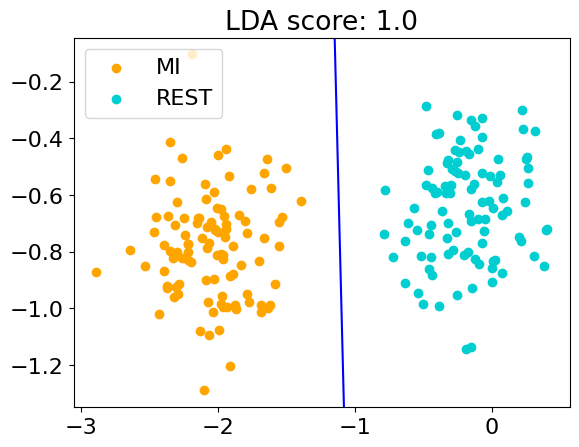

In [47]:
# Get the accuracy at training data
acc_tr = lda.score(Gtr, Ytr)

# Plot first 2 CSP features of the training set + the LDA decision boundary
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("LDA score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)

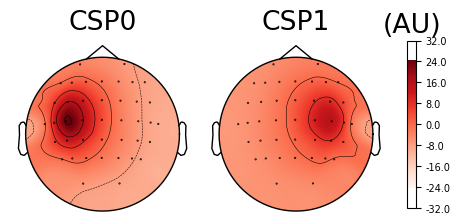

In [48]:
# Plot CSP patterns
fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='(AU)', size=1.5, cmap='Reds')

## Online model evaluation without BOTDA


### Define recalibration and testing data

Recalibration data is simulated as the first 20 trials of the application session, while the remaining trials define the testing data.



In [49]:
Xte = epochs_test_array[20:].copy()  # Epoched data as a numpy array
Yte = epochs_test.events[20:,2].copy()
# use the first 20 samples for validation
Xval = epochs_test_array[:20].copy()  # Epoched data as a numpy array
Yval = epochs_test.events[:20,2].copy()

### Evaluate the model

In [50]:
# Calculate testing and validation CSP features
Gte = csp.transform(Xte)
Gval = csp.transform(Xval)

# Predict the testing classes using LDA and calculate testing accuracy
y_predict_lda = lda.predict(Gte)
acc_lda = (accuracy_score(Yte, y_predict_lda))

# Print testing LDA accuracy
print('Testing accuracy LDA (without BOTDA): ' + str(round(acc_lda, 3)))

Testing accuracy LDA (without BOTDA): 0.506


## Online model evaluation with BOTDA

### Define BOTDA parameters

In [51]:
rango_cl = [1]
rango_e = [0.1]
metric = 'euclidean'
innerkfold = None
outerkfold = 20
M=20
norm=None
eps = 1e+6
SVMAX = 20

In [52]:
y_predict_ot = []  # Initialize list to store predicted classes
Transp = []   # Initialize list to store transported features
algorithm_support = []  # Initialize list to store the transport cost values

# Select source subset based on CV and validation features
G_botdatr, Y_botdatr, reg_botda=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)
# Create BOTDA object
botda = BOTDA(reg_botda, lda, metric)

# For each testing trial
for re in range(0, len(Yte)):
    # Testing trial
    Xte_ = Xte[re:re+1]
    Yte_ = Yte[re:re+1]

    # Append to the Xval subset the current testing trial
    Xval_ = np.vstack((Xval.copy(), Xte_))
    Yval_ = np.hstack((Yval.copy(), Yte_))

    # Calculate validation and testing CSP features
    Gval_ = csp.transform(Xval_)
    Gte_ = csp.transform(Xte_)

    # Learn the transport based on the selected source subset and the current validation subset
    botda.fit(G_botdatr, Gval_, Yval_)
    # Transport testing feature and predict its class
    Gte_transported, y_pred_ = botda.transform(Gte_)
    Transp.append(Gte_transported)
    y_predict_ot.append(y_pred_)
    # Calculate the transport cost
    botda_matrix = botda.coupling_
    distance_ot = botda.cost_
    algorithm_support.append(botda_matrix[-1, :] @ distance_ot[-1,:])

Gte_ot = np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

# Calculate accuracy
acc_OT = accuracy_score(Yte,y_predict_ot)
print('Testing accuracy LDA + BOTDA: ' + str(round(acc_OT, 3)))

Testing accuracy LDA + BOTDA: 0.889


### Plotting the results

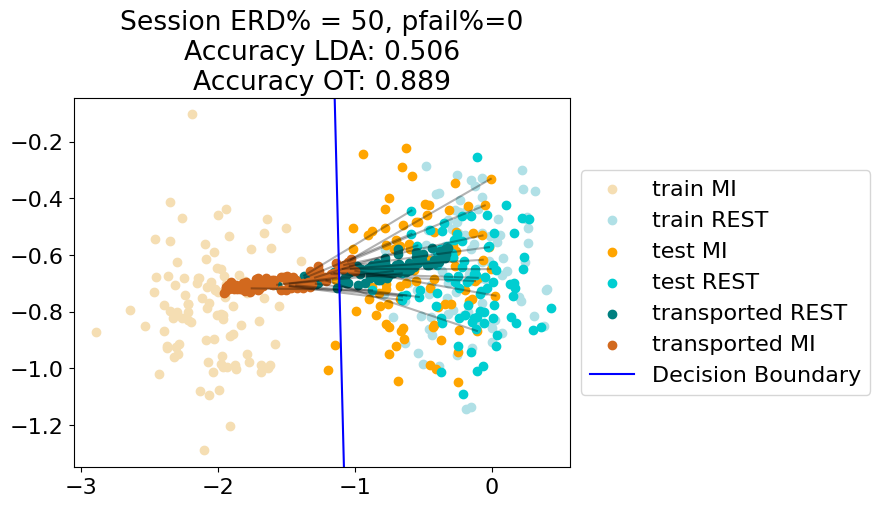

In [53]:
ft = Gte
ft_ot = Gte_ot

x = np.linspace(-1,3,500)
y = np.linspace(2,8,500)
X,Y = np.meshgrid(x,y)
pos = np.array([X.flatten(),Y.flatten()]).T
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='wheat', label='train MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='powderblue', label='train REST')
# plot the subset where the transport is learned
axs.scatter(ft[Yte==1, 0], ft[Yte==1, 1], c='orange', label='test MI')
axs.scatter(ft[Yte==2, 0], ft[Yte==2, 1], c='darkturquoise', label='test REST')
axs.scatter(ft_ot[Yte==2, 0], ft_ot[Yte==2, 1], c='teal', label='transported REST')
axs.scatter(ft_ot[Yte==1, 0], ft_ot[Yte==1, 1], c='chocolate', label='transported MI')
outernMI = np.argsort(ft[Yte==1, 0])[len(ft[Yte==1, 0])-10:]
outernR = np.argsort(ft[Yte==2, 0])[0:10]
plt.plot([ft[Yte==1, 0][outernMI],ft_ot[Yte==1, 0][outernMI]], [ft[Yte==1, 1][outernMI], ft_ot[Yte==1, 1][outernMI]],'k-', alpha = 0.3)
plt.plot([ft[Yte==2, 0][outernR],ft_ot[Yte==2, 0][outernR]], [ft[Yte==2, 1][outernR], ft_ot[Yte==2, 1][outernR]],'k-', alpha = 0.3)

b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue', label = 'Decision Boundary')

axs.set_ylim(ylim)
axs.set_xlim(xlim)
axs.set_title('Session ERD% = 50, pfail%=0' + '\nAccuracy LDA: ' + str(round(acc_lda, 3)) + '\nAccuracy OT: ' + str(round(acc_OT, 3)) )
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Part 2: Adaptation success when performed failed trials

While training data remains the same, here we use as for model evaluation a session with high ERD% but large wrongly performed trials. The class swap is done from an original session without wrong trials.

In [60]:
wget.download("https://zenodo.org/records/13760210/files/S_45_epo.fif?download=1",
              out="S_45_epo.fif")
epochs_test = mne.read_epochs("S_45_epo.fif", preload=True, verbose=False)
epochs_test = epochs_test.resample(250)
epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)



In [61]:
# swap labels
p = 0.3 #30% of failed trials
Yte_new = epochs_test.events[:,2].copy()

idx_2 = np.where(Yte_new == 2)[0] # Rest class
idx_1 = np.where(Yte_new == 1)[0] # MI class
n_change_2 = np.array(sample(list(idx_2), int(p*len(idx_2))))
n_change_1 = np.array(sample(list(idx_1), int(p*len(idx_1))))
Yte_new[n_change_2] = 1
Yte_new[n_change_1] = 2
print("resulted p-failed: ",(len(n_change_2)+len(n_change_1))/len(Yte_new))

resulted p-failed:  0.3


## Online model evaluation without BOTDA


### Define recalibration and testing data

As before, recalibration data is simulated as the first 20 trials of the application session, while the remaining trials define the testing data.



In [63]:
Xte = epochs_test_array[20:].copy()  # Epoched data as a numpy array
Yte = Yte_new[20:].copy()
# use the first 20 samples for validation
Xval = epochs_test_array[:20].copy()  # Epoched data as a numpy array
Yval = Yte_new[:20].copy()

### Evaluate the model

We used the same trained model as before

In [64]:
# Calculate testing and validation CSP features
Gte = csp.transform(Xte)
Gval = csp.transform(Xval)

# Predict the testing classes using LDA and calculate testing accuracy
y_predict_lda = lda.predict(Gte)
acc_lda = (accuracy_score(Yte, y_predict_lda))

# Print testing LDA accuracy
print('Testing accuracy LDA (without BOTDA): ' + str(round(acc_lda, 3)))

Testing accuracy LDA (without BOTDA): 0.689


## Online model evaluation with BOTDA

In [65]:
y_predict_ot = []  # Initialize list to store predicted classes
Transp = []   # Initialize list to store transported features
algorithm_support_fatigue = []  # Initialize list to store the transport cost values

# Select source subset based on CV and validation features
G_botdatr, Y_botdatr, reg_botda=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)
# Create BOTDA object
botda = BOTDA(reg_botda, lda, metric)

# For each testing trial
for re in range(0, len(Yte)):
    # Testing trial
    Xte_ = Xte[re:re+1]
    Yte_ = Yte[re:re+1]

    # Append to the Xval subset the current testing trial
    Xval_ = np.vstack((Xval.copy(), Xte_))
    Yval_ = np.hstack((Yval.copy(), Yte_))

    # Calculate validation and testing CSP features
    Gval_ = csp.transform(Xval_)
    Gte_ = csp.transform(Xte_)

    # Learn the transport based on the selected source subset and the current validation subset
    botda.fit(G_botdatr, Gval_, Yval_)
    # Transport testing feature and predict its class
    Gte_transported, y_pred_ = botda.transform(Gte_)
    Transp.append(Gte_transported)
    y_predict_ot.append(y_pred_)
    # Calculate the transport cost
    botda_matrix = botda.coupling_
    distance_ot = botda.cost_
    algorithm_support_fatigue.append(botda_matrix[-1, :] @ distance_ot[-1,:])

Gte_ot = np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

# Calculate accuracy
acc_OT = accuracy_score(Yte,y_predict_ot)
print('Testing accuracy LDA + BOTDA: ' + str(round(acc_OT, 3)))

Testing accuracy LDA + BOTDA: 0.717


### Plotting the results

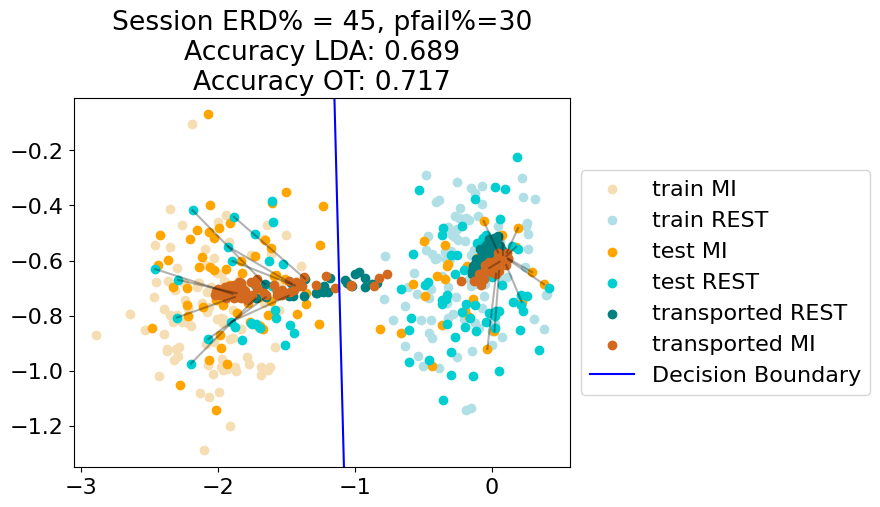

In [67]:
ft = Gte
ft_ot = Gte_ot

x = np.linspace(-1,3,500)
y = np.linspace(2,8,500)
X,Y = np.meshgrid(x,y)
pos = np.array([X.flatten(),Y.flatten()]).T
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='wheat', label='train MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='powderblue', label='train REST')
# plot the subset where the transport is learned
axs.scatter(ft[Yte==1, 0], ft[Yte==1, 1], c='orange', label='test MI')
axs.scatter(ft[Yte==2, 0], ft[Yte==2, 1], c='darkturquoise', label='test REST')
axs.scatter(ft_ot[Yte==2, 0], ft_ot[Yte==2, 1], c='teal', label='transported REST')
axs.scatter(ft_ot[Yte==1, 0], ft_ot[Yte==1, 1], c='chocolate', label='transported MI')
outernMI = np.argsort(ft[Yte==1, 0])[len(ft[Yte==1, 0])-10:]
outernR = np.argsort(ft[Yte==2, 0])[0:10]
plt.plot([ft[Yte==1, 0][outernMI],ft_ot[Yte==1, 0][outernMI]], [ft[Yte==1, 1][outernMI], ft_ot[Yte==1, 1][outernMI]],'k-', alpha = 0.3)
plt.plot([ft[Yte==2, 0][outernR],ft_ot[Yte==2, 0][outernR]], [ft[Yte==2, 1][outernR], ft_ot[Yte==2, 1][outernR]],'k-', alpha = 0.3)

b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue', label = 'Decision Boundary')

axs.set_ylim(ylim)
axs.set_xlim(xlim)
axs.set_title('Session ERD% = 45, pfail%=30' + '\nAccuracy LDA: ' + str(round(acc_lda, 3)) + '\nAccuracy OT: ' + str(round(acc_OT, 3)) )
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()